# SN-GAN Training

This notebook demonstrates training a Spectral Normalization GAN (SN-GAN) on various datasets like shape3d, cars3d, dsprites 

The SN-GAN uses spectral normalization in the discriminator to control the Lipschitz constant, leading to more stable training compared to vanilla GANs.

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Add the project root to the path to import our modules
sys.path.append('jupyter NBs/GAN (Tests)')

# Import our custom modules
from datasets.shapes3d import Shapes3D
from gan.trainer import GANTrainer
from gan.architecture import Generator, Discriminator
from gan.loss import get_loss

# Set up device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Memory cleanup utility
def free_memory():
    """
    Release RAM and CUDA memory occupied by tensors, models, and data loaders.
    """
    import gc
    import torch

    # Run Python garbage collector
    gc.collect()

    # Empty CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("RAM and CUDA memory have been freed.")

# Example: call after training (you can also call manually later)
free_memory()

In [2]:
# Set random seeds for reproducibility
seed_number = 42

torch.manual_seed(seed_number)
np.random.seed(seed_number)

random.seed(seed_number)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_number)
    torch.cuda.manual_seed_all(seed_number)

# For consistent results
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Shapes3d

In [3]:
# Dataset Configuration
print("Setting up Shapes3D dataset...")

# For this experiment, we'll allow all factors to vary
# This gives us the full diversity of the dataset
selected_factors = ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors

# root = '/data/amin/shapes3d/'  # Adjust this path as needed
root = 'data/shapes3d/'  # Local path for testing

# Create dataset instance
dataset = Shapes3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Dataset loaded with {len(dataset)} images")
print(f"Image size: {dataset.img_size}")
print(f"Selected factors: {dataset.selected_factors}")

# Create DataLoader
batch_size = 64
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

Setting up Shapes3D dataset...
Dataset loaded with 480000 images
Image size: (3, 64, 64)
Selected factors: ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
DataLoader created with batch size: 64
Number of batches: 7500


Sample images from the Shapes3D dataset:


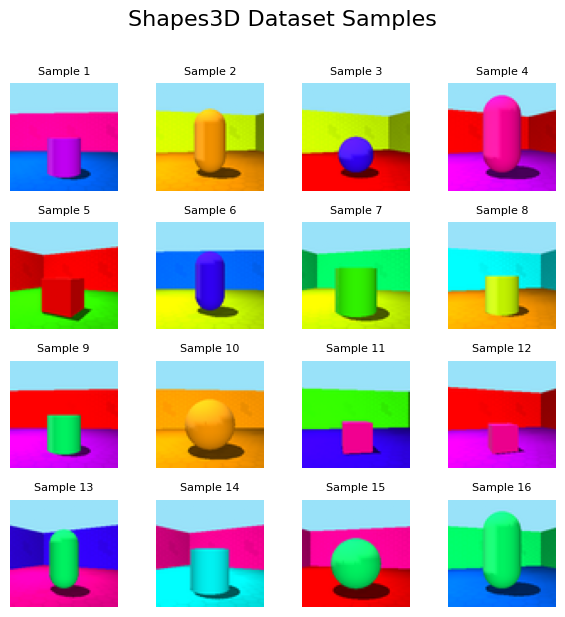

In [4]:
# Visualize some sample data
def show_data_samples(dataset, n_samples=16):
    """Display a grid of sample images from the dataset."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    
    # Generate n_samples random indices
    indices = random.sample(range(len(dataset)), n_samples)
    
    for i, idx in enumerate(indices):
        img, factors = dataset[idx]
        
        # Convert from tensor to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    fig.suptitle('Shapes3D Dataset Samples', fontsize=16, y=1.02, ha='center')  # Well aligned title
    plt.show()

print("Sample images from the Shapes3D dataset:")
show_data_samples(dataset)

In [23]:
# SN-GAN Configuration
print("Setting up SN-GAN trainer...")

# Model hyperparameters
latent_dim = 10
img_size = (3, 64, 64)  # C, H, W
learning_rate_g = 1e-4
learning_rate_d = 1e-4
beta1 = 0.9  # SN-GAN typically uses beta1=0
beta2 = 0.999

# Create models explicitly (no more defaults inside GANTrainer)
generator = Generator(latent_dim=latent_dim, img_size=img_size, use_batchnorm=True, negative_slope=0.2)
# Enable spectral normalization in the discriminator for SN-GAN
discriminator = Discriminator(img_size=img_size, use_spectral_norm=True)

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Create optimizers explicitly
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(beta1, beta2))

# Create SN-GAN trainer (now requires models and optimizers)
trainer = GANTrainer(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    loss_type='sngan',  # hinge loss
    loss_kwargs={},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created")
print(f"Generator parameters: {sum(p.numel() for p in trainer.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer.discriminator.parameters()):,}")
print(f"Loss type: {trainer.loss_type}")
print(f"Device: {trainer.device}")

Setting up SN-GAN trainer...
SN-GAN trainer created
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: sngan
Device: cuda


In [24]:
# Training Configuration
epochs = 1  # Adjust based on your computational resources
print(f"Starting SN-GAN training for {epochs} epochs...")

# Train the model
trainer.train(dataloader, epochs)

print("Training completed!")

Starting SN-GAN training for 1 epochs...
Starting training for 1 epochs...
Loss type: sngan
Device: cuda


Epoch 0: 100%|██████████| 7500/7500 [02:08<00:00, 58.28it/s, D_loss=0.1119, G_loss=1.4745]

Epoch [1/1] - D_loss: 0.0880, G_loss: 1.5874
Training completed!
Training completed!


Plotting training losses...


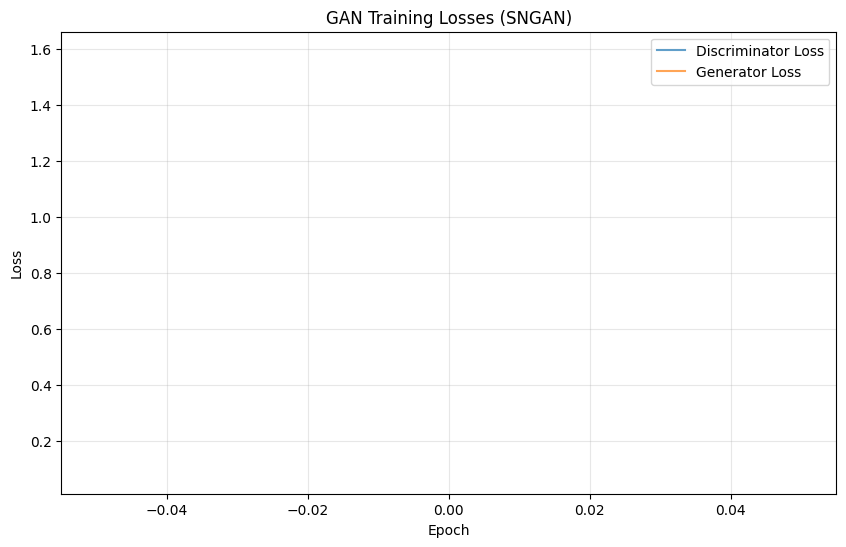


Training Summary:
Final Discriminator Loss: 0.0880
Final Generator Loss: 1.5874
Average Discriminator Loss: 0.0880
Average Generator Loss: 1.5874


In [25]:
# Visualize Training Progress
print("Plotting training losses...")
trainer.plot_losses()

# Show training history summary
if trainer.history['d_loss'] and trainer.history['g_loss']:
    print(f"\nTraining Summary:")
    print(f"Final Discriminator Loss: {trainer.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN...


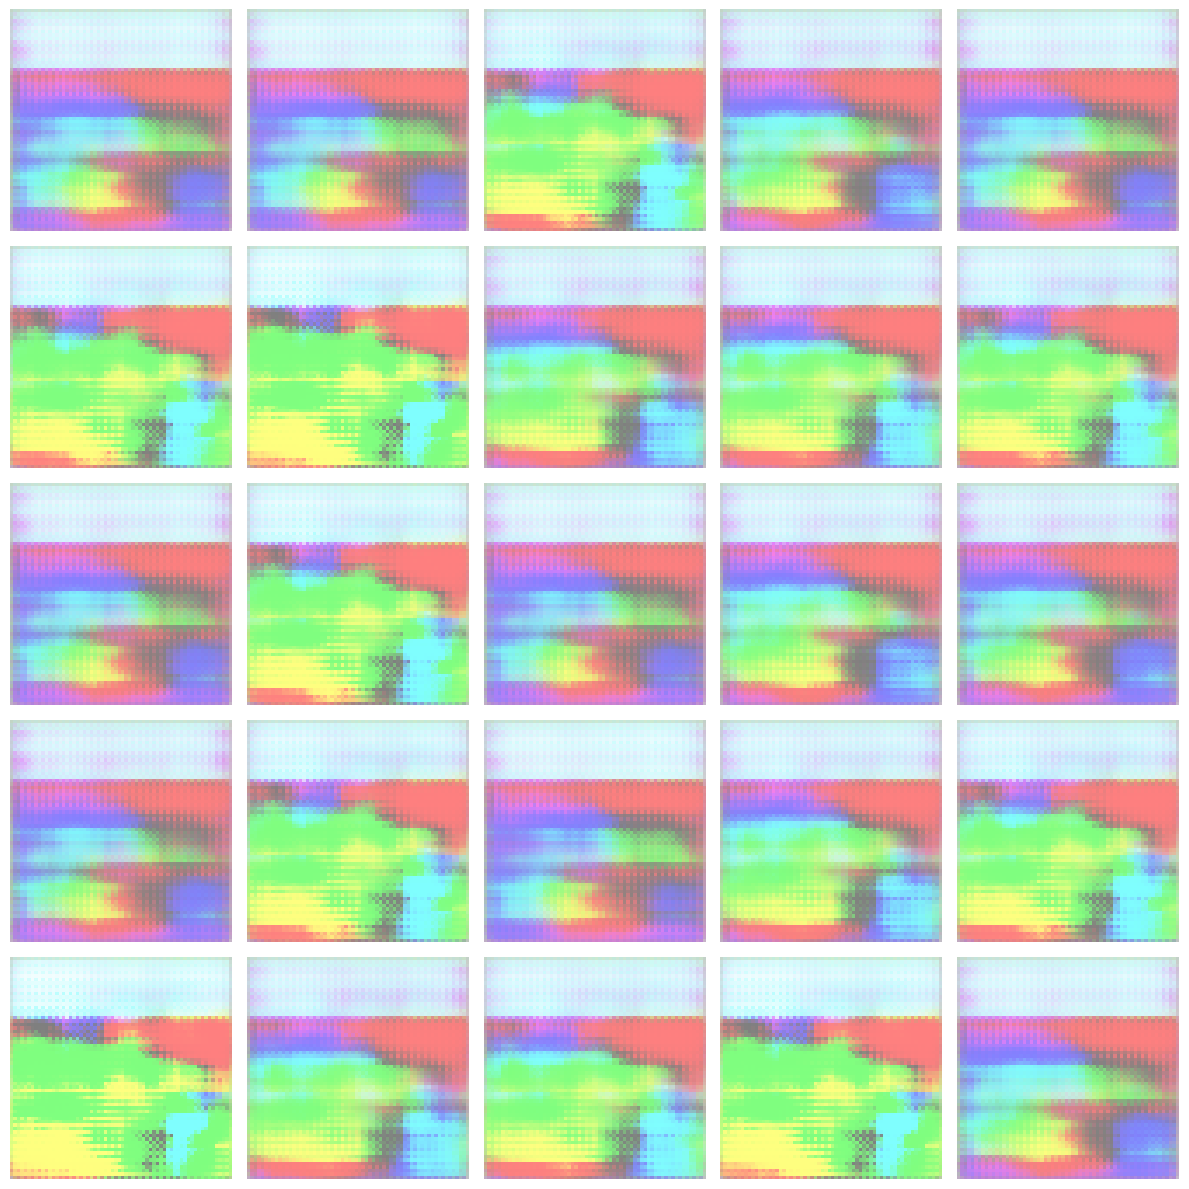

In [27]:
# Generate and Display Sample Images
print("Generating sample images from trained SN-GAN...")
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# dsprites

In [28]:
# Dataset Configuration for DSprites
print("Setting up DSprites dataset...")

# Import DSprites dataset
from datasets.dsprites import DSprites

# For dsprites, we'll select all factors except color (which has only one value)
# DSprites factors: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
selected_factors = ['shape', 'scale', 'orientation', 'posX', 'posY']
not_selected_factors_index_value = {'color': 0}  # Fix color to its only value

root = 'data/dsprites/'  # Local path for dsprites dataset

# Create dataset instance
dataset_dsprites = DSprites(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
    drop_color_factor=True  # Drop color factor since it has only one value
)

print(f"DSprites dataset loaded with {len(dataset_dsprites)} images")
print(f"Image size: {dataset_dsprites.img_size}")
print(f"Selected factors: {dataset_dsprites.selected_factors}")

# Create DataLoader
batch_size_dsprites = 64
dataloader_dsprites = DataLoader(
    dataset_dsprites, 
    batch_size=batch_size_dsprites, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size_dsprites}")
print(f"Number of batches: {len(dataloader_dsprites)}")

Setting up DSprites dataset...
DSprites dataset loaded with 737280 images
Image size: (1, 64, 64)
Selected factors: ['shape', 'scale', 'orientation', 'posX', 'posY']
DataLoader created with batch size: 64
Number of batches: 11520
DSprites dataset loaded with 737280 images
Image size: (1, 64, 64)
Selected factors: ['shape', 'scale', 'orientation', 'posX', 'posY']
DataLoader created with batch size: 64
Number of batches: 11520


Sample images from the DSprites dataset:


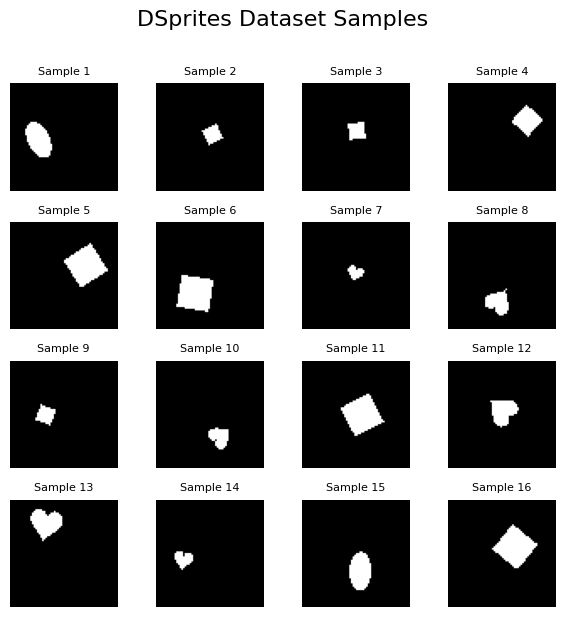

In [29]:
# Visualize some sample data from DSprites
def show_dsprites_samples(dataset, n_samples=16):
    """Display a grid of sample images from the DSprites dataset."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    
    # Generate n_samples random indices
    indices = random.sample(range(len(dataset)), n_samples)
    
    for i, idx in enumerate(indices):
        img, factors = dataset[idx]
        
        # Convert from tensor to numpy - DSprites images are grayscale (1 channel)
        img_np = img.squeeze().numpy()  # Remove channel dimension for grayscale
        
        axes[i].imshow(img_np, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    fig.suptitle('DSprites Dataset Samples', fontsize=16, y=1.02, ha='center')
    plt.show()

print("Sample images from the DSprites dataset:")
show_dsprites_samples(dataset_dsprites)

In [30]:
# SN-GAN Configuration for DSprites
print("Setting up SN-GAN trainer for DSprites...")

# Model hyperparameters for DSprites (grayscale images)
latent_dim_dsprites = 10
img_size_dsprites = (1, 64, 64)  # Grayscale images (1 channel)
learning_rate_g_dsprites = 1e-4
learning_rate_d_dsprites = 1e-4
beta1_dsprites = 0.9
beta2_dsprites = 0.999

# Create models for DSprites (1-channel input)
generator_dsprites = Generator(latent_dim=latent_dim_dsprites, img_size=img_size_dsprites)
# Enable spectral normalization in the discriminator for SN-GAN
discriminator_dsprites = Discriminator(img_size=img_size_dsprites, use_spectral_norm=True)

# Move models to device
generator_dsprites = generator_dsprites.to(device)
discriminator_dsprites = discriminator_dsprites.to(device)

# Create optimizers
g_optimizer_dsprites = optim.Adam(generator_dsprites.parameters(), lr=learning_rate_g_dsprites, betas=(beta1_dsprites, beta2_dsprites))
d_optimizer_dsprites = optim.Adam(discriminator_dsprites.parameters(), lr=learning_rate_d_dsprites, betas=(beta1_dsprites, beta2_dsprites))

# Create SN-GAN trainer for DSprites
trainer_dsprites = GANTrainer(
    generator=generator_dsprites,
    discriminator=discriminator_dsprites,
    g_optimizer=g_optimizer_dsprites,
    d_optimizer=d_optimizer_dsprites,
    loss_type='sngan',  # hinge loss
    loss_kwargs={},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created for DSprites")
print(f"Generator parameters: {sum(p.numel() for p in trainer_dsprites.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_dsprites.discriminator.parameters()):,}")
print(f"Loss type: {trainer_dsprites.loss_type}")
print(f"Device: {trainer_dsprites.device}")
print(f"Image size: {img_size_dsprites}")

Setting up SN-GAN trainer for DSprites...
SN-GAN trainer created for DSprites
Generator parameters: 381,697
Discriminator parameters: 378,049
Loss type: sngan
Device: cuda
Image size: (1, 64, 64)


In [31]:
# Training Configuration for DSprites
epochs_dsprites = 2  # Adjust based on your computational resources
print(f"Starting SN-GAN training on DSprites for {epochs_dsprites} epochs...")

# Train the model on DSprites
trainer_dsprites.train(dataloader_dsprites, epochs_dsprites)

print("DSprites training completed!")

Starting SN-GAN training on DSprites for 2 epochs...
Starting training for 2 epochs...
Loss type: sngan
Device: cuda


Epoch 0: 100%|██████████| 11520/11520 [03:11<00:00, 60.19it/s, D_loss=0.9075, G_loss=0.7879]


Epoch [1/2] - D_loss: 0.4226, G_loss: 1.2156


Epoch 1: 100%|██████████| 11520/11520 [03:12<00:00, 59.96it/s, D_loss=1.6348, G_loss=0.5498]

Epoch [2/2] - D_loss: 1.2660, G_loss: 0.6550
Training completed!
DSprites training completed!


Plotting DSprites training losses...


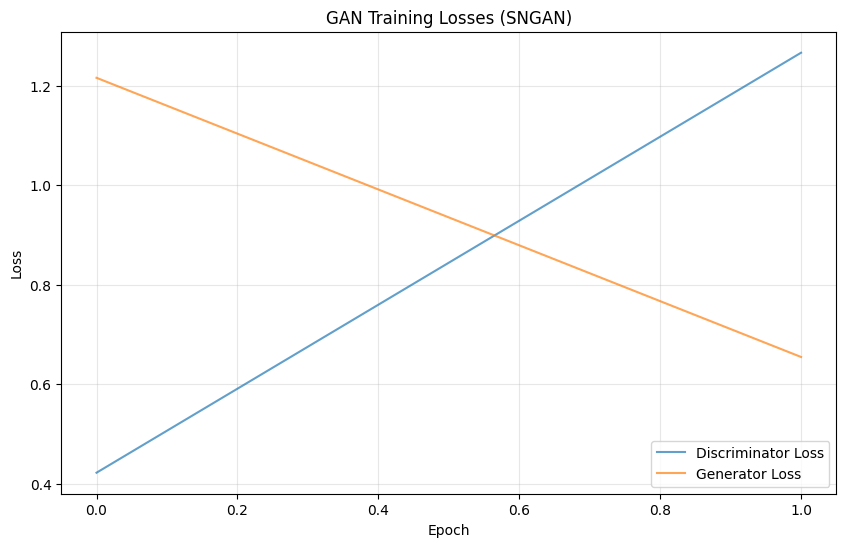


DSprites Training Summary:
Final Discriminator Loss: 1.2660
Final Generator Loss: 0.6550
Average Discriminator Loss: 0.8443
Average Generator Loss: 0.9353


In [32]:
# Visualize DSprites Training Progress
print("Plotting DSprites training losses...")
trainer_dsprites.plot_losses()

# Show training history summary for DSprites
if trainer_dsprites.history['d_loss'] and trainer_dsprites.history['g_loss']:
    print(f"\nDSprites Training Summary:")
    print(f"Final Discriminator Loss: {trainer_dsprites.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer_dsprites.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer_dsprites.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer_dsprites.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN on DSprites...


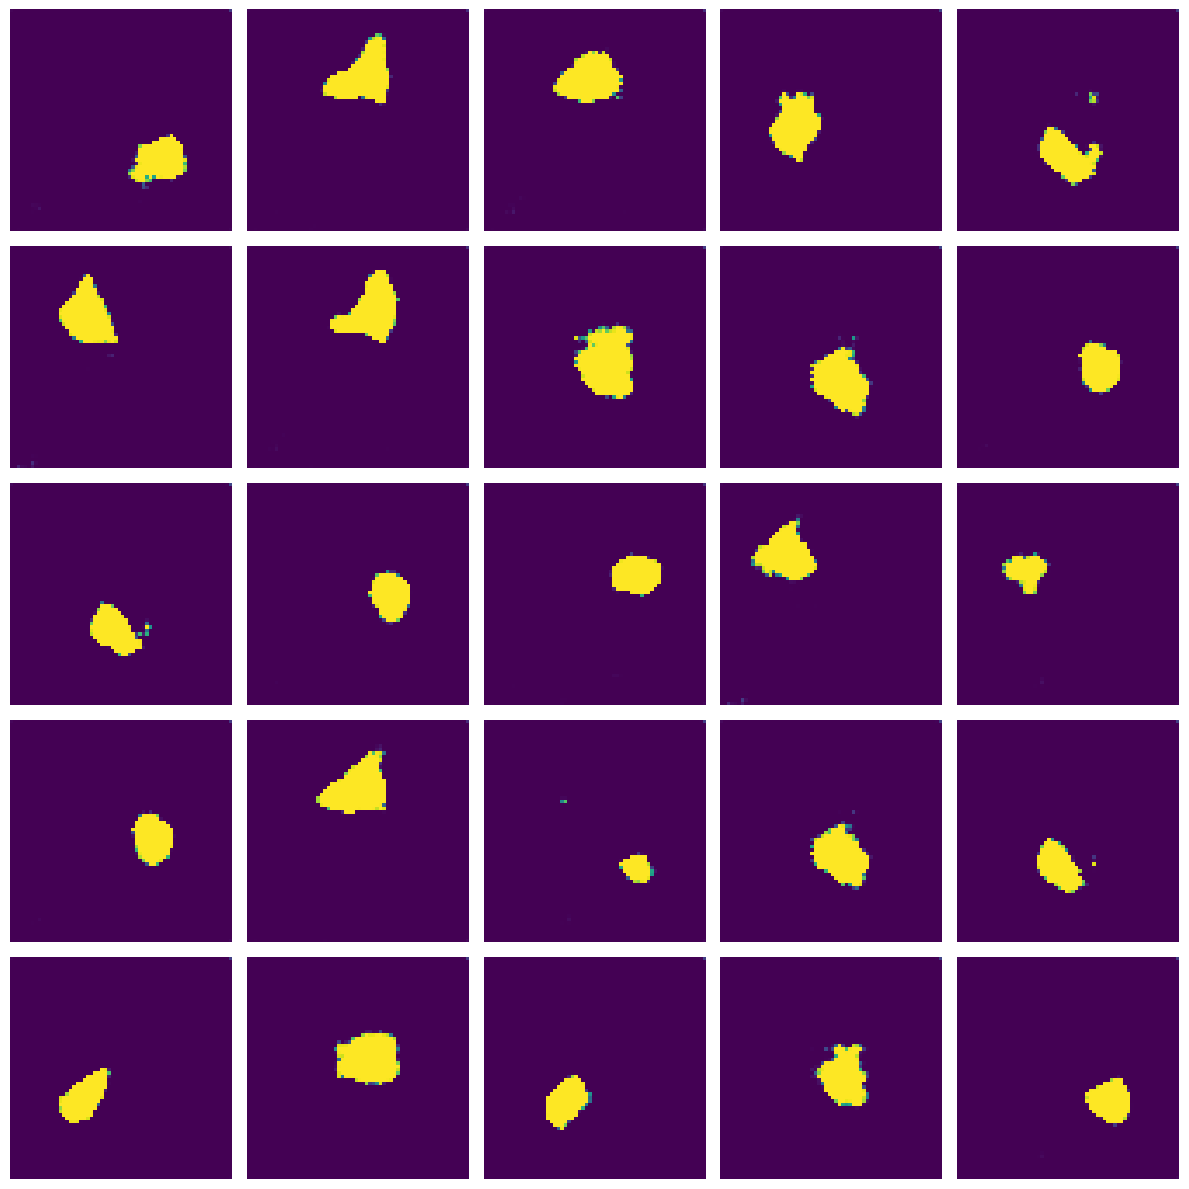

In [39]:
# Generate and Display Sample Images from DSprites SN-GAN
print("Generating sample images from trained SN-GAN on DSprites...")
trainer_dsprites.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))